# Friend of the Pod? 
---
---

##  Problem Statement
It’s very common in the United States, especially in political media, to hear Liberals and the Left referred to interchangeably, but is this really the case? In a sample poll, 100% of my uncles were either unable to tell them apart, or at least considered it a distinction without a difference

But, with a little web scraping and some natural language processing, can we prove that it’s not very hard to tell the Liberals apart from the Left? 


## Hypothesis?
Are Liberals and the Left indistinguishable from one another? 

## The Dataset

---
### Import and read in
---

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
from datetime import datetime
from pmaw import PushshiftAPI
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, f1_score, recall_score, precision_score

sns.set(style="ticks", context="talk")
plt.style.use("fivethirtyeight")

In [5]:
url = 'https://api.pushshift.io/reddit/search/submission'
subred1 = 'FriendsofthePod'
subred2 = 'InformedTankie'
subred3 = 'communism'
subred4 = 'IWW'

iters = 60000 # number of posts to be scrapped from each subreddit
# weights are used to make a more balanced dataset 
weight1 = 1
weight2 = 1
weight3 = 1/30
weight4 = 1/20

---
### PushShift API
---

In [6]:
api = PushshiftAPI()

In [7]:
df = pd.DataFrame() 
weights = [weight1, weight2, weight3, weight4]
for idx, i in enumerate([subred1, subred2, subred3, subred4]):
    posts = api.search_submissions(subreddit=i, limit=(int(iters*weights[idx])), safe_exit=True)
    post_list = [post for post in posts]
    df_i = pd.DataFrame(post_list)
    df_i = df_i[['subreddit', 'title', 'selftext']]
    df = pd.concat([df, df_i])

Response cache key: 24d00f3619cf1000ca9a722bdaa96a1e
52761 result(s) not found in Pushshift
Total:: Success Rate: 100.00% - Requests: 27 - Batches: 3 - Items Remaining: 5035
Total:: Success Rate: 100.00% - Requests: 51 - Batches: 6 - Items Remaining: 2949
Total:: Success Rate: 100.00% - Requests: 72 - Batches: 9 - Items Remaining: 1286
5 result(s) not found in Pushshift
Total:: Success Rate: 100.00% - Requests: 88 - Batches: 11 - Items Remaining: 190
Total:: Success Rate: 100.00% - Requests: 98 - Batches: 12 - Items Remaining: 0
Response cache key: d35625d549009de4a7a1e9dfc64afae4
56542 result(s) not found in Pushshift
Total:: Success Rate: 100.00% - Requests: 41 - Batches: 5 - Items Remaining: 238
Total:: Success Rate: 100.00% - Requests: 52 - Batches: 7 - Items Remaining: 0
Response cache key: e3ba132c4044e8ead18d7a8b991fb574
Total:: Success Rate: 100.00% - Requests: 20 - Batches: 2 - Items Remaining: 0
Response cache key: cf9592def6c81a2f7472d2f2c4dd54fb
Total:: Success Rate: 100.00

--- 
### Data Cleaning
---
Removing any blank, self-referencing, or deleted posts 

In [8]:
for i in ['', ' ', '[removed]', '[deleted]', 'deleted', 'blank', 'Title', 'title', 'NaN', 'nan']:
    df = df[(df.selftext != i)]
df = df[(df.selftext.notnull())]

In [9]:
df.head()

,subreddit,title,selftext
1,FriendsofthePod,HELP! I'm an American living it in Canada and ...,I'm looking to do more than vote this year but...
6,FriendsofthePod,Two Questions in response to “That’s the Ticket”,1- Is anyone else surprised that Biden didn’t ...
10,FriendsofthePod,What A Day: Clown v. Board of Education by Sar...,"*""Fuck politics - but I'm always happy to talk..."
11,FriendsofthePod,How do I find the slack channel url,I have heard the slack channel referenced in m...
12,FriendsofthePod,I’ve got a strong feeling that Pod Save The Wo...,"At best, they will probably only briefly menti..."


In [10]:
df.selftext.isnull().sum()

0

In [11]:
df.subreddit.value_counts()

FriendsofthePod    1781
IWW                 670
InformedTankie      604
communism           593
Name: subreddit, dtype: int64

In [12]:
df.selftext.nunique()

3495

In [13]:
df.selftext

1       I'm looking to do more than vote this year but...
6       1- Is anyone else surprised that Biden didn’t ...
10      *"Fuck politics - but I'm always happy to talk...
11      I have heard the slack channel referenced in m...
12      At best, they will probably only briefly menti...
                              ...                        
2984     According to a [recent study](https://abacusd...
2986    Welcome to our weekly *Shop talk* thread! Use ...
2988    I've been wanting to join the IWW as a working...
2990    I just joined the IWW a couple days ago, and I...
2994    Hello, I was wondering: can teenagers join the...
Name: selftext, Length: 3648, dtype: object

---
### Export
---

In [14]:
df.to_csv("./data/scrapped_subreddits.csv")

---
### EDA 
---

#### Word Frequency w/ CountVectorizor

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
X = df['selftext'].copy()
cvec = CountVectorizer(min_df=2, max_df=0.3, ngram_range= (1,1), stop_words='english')
cvec.fit(X)
X = cvec.transform(X)
X_df = pd.DataFrame(X.todense(), columns=cvec.get_feature_names())
X_df.head()
# cvec.get_feature_names()[:20]
X_df.sum().sort_values(ascending=False).head(40)

amp                         25330
com                         21301
www                         15035
trump                       13212
h_sid                        8969
59d5592b0a21f78c3a091e84     8882
utm_source                   6276
utm_medium                   6263
utm_campaign                 6116
html                         5945
email                        5924
hive                         5094
twitter                      4894
new                          4161
2020                         4143
news                         4062
politics                     4039
status                       3548
house                        3442
2019                         3246
2018                         3087
president                    2938
state                        2418
coronavirus                  2414
nytimes                      2259
crooked                      2211
white                        2181
cnn                          2024
world                        1976
time          

Making a list of extra stop words that mostly seem to be fragments from the vectorizing process breaking apart URLs

In [16]:
extra_stop_words = ['amp', 'com', 'www', 'http', 'https' 'utm_source', 'utm_medium', 'utm_campaign', 
               'html', 'h_sid', '59d5592b0a21f78c3a091e84', 'status', 'org', 'index', ]

Text(0.5, 0, 'Word Frequency')

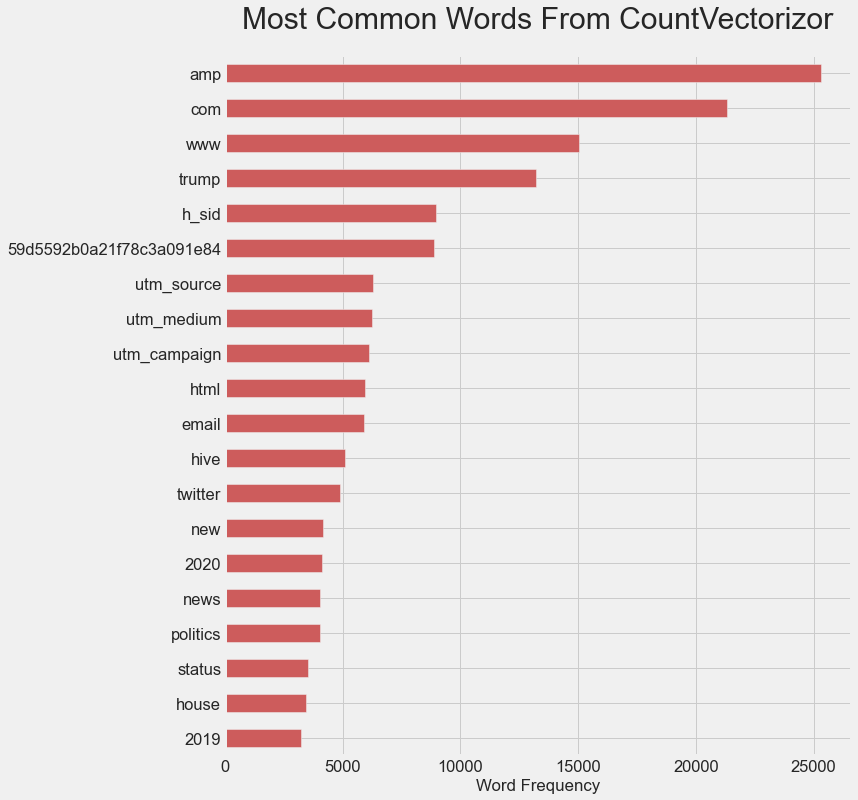

In [17]:
plt.figure(figsize=(10, 12))
X_df.sum().sort_values(ascending=False).head(20).sort_values(ascending=True).plot(kind='barh', color='indianred')
plt.title('Most Common Words From CountVectorizor', fontsize=30, y=1.03)
plt.xlabel('Word Frequency')

Many of these were the kind of politically relevent we would hope to see at the top of the list, but some of the terms were clearly collateral leftover from the tokenizing process, so the following list was isolated as extra stop words that would be removed in the tokenizer-Lemmatizer function 

#### Sentiment Analysis

In [18]:
from transformers import pipeline

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [19]:
sent = pipeline('sentiment-analysis')

In [20]:
# sentiment analysis as per GA DSI Week 5 lesson: Word Vectors
# using the first thousand characters in each selftext string
df['sentiment'] = df['selftext'].astype(str).map(lambda x: sent(x[:1000])[0]['label'])

In [21]:
df['sentiment'] = df['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': -1})
df.groupby('subreddit')['sentiment'].describe().T

subreddit,FriendsofthePod,IWW,InformedTankie,communism
count,1781.000000,670.000000,604.000000,593.000000
mean,-0.581134,-0.555224,-0.327815,-0.487352
std,0.814036,0.832322,0.945525,0.873943
min,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000
75%,-1.000000,-1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [22]:
df.groupby('subreddit')['sentiment'].value_counts()

subreddit        sentiment
FriendsofthePod  -1           1408
                  1            373
IWW              -1            521
                  1            149
InformedTankie   -1            401
                  1            203
communism        -1            441
                  1            152
Name: sentiment, dtype: int64

In [23]:
df.groupby('subreddit')['sentiment'].mean()

subreddit
FriendsofthePod   -0.581134
IWW               -0.555224
InformedTankie    -0.327815
communism         -0.487352
Name: sentiment, dtype: float64

Text(0.5, 1.04, 'Sentiment Analysis Shows Most Posts Express Mostly Negative Sentiment')

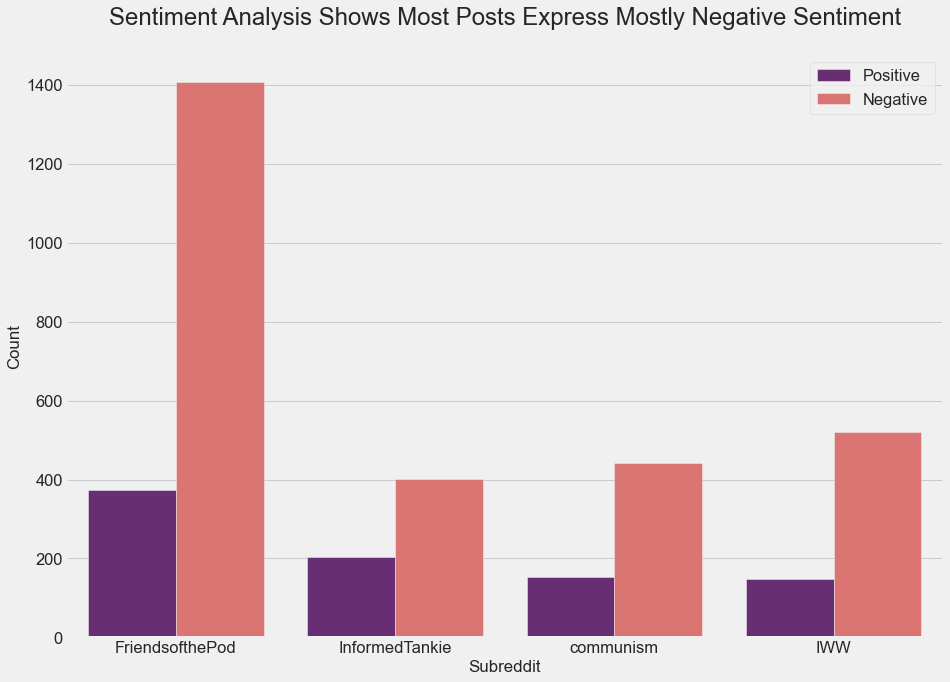

In [24]:
plt.figure(figsize=(14, 10))
sns.countplot(data=df, x='subreddit', hue='sentiment', hue_order=[1, -1], 
              palette='magma', saturation=0.7)
plt.legend(['Positive', 'Negative'])
plt.xlabel('Subreddit')
plt.ylabel('Count')
plt.title('Sentiment Analysis Shows Most Posts Express Mostly Negative Sentiment',
         fontsize=24, y=1.04)

As one might expect, most political posts tend to be based around pretty negative sentiment, and since they seemed to follow a pretty similar pattern of mostly negative sentiment, decided not to use this in the model

--- 
### Feature Engineering
---

#### Tokenizing & Lemmatizing
Using a Regex Tokenizer to split the words out from each post then Lemmatize them.
Then our extra stop words are removed before being joined back into a string 

In [25]:
file = "./data/scrapped_subreddits.csv"
df = pd.read_csv(file)

# letting it read in the Unnamed column then dropping it fixes any indexing weirdness from the concatination process 
df.drop(columns='Unnamed: 0', inplace=True)

In [26]:
tokenizer = RegexpTokenizer(r"\w+")
lemmatizer = WordNetLemmatizer()
def toklem(string):
    """
    This function 
    """
    tokens = tokenizer.tokenize(string.lower())
    lemmed = [lemmatizer.lemmatize(token) for token in tokens]
    # filtering out custom words as per https://www.dezyre.com/recipes/add-custom-stopwords-and-then-remove-them-from-text
    filtered = [words for words in lemmed if not words in extra_stop_words]
    separator = ' '
    return separator.join(filtered)
df['selftext'] = df['selftext'].astype(str).map(toklem)
df['title'] = df['title'].astype(str).map(toklem)
# remobing any null selftext entries in case any were created in the Tokenizer-Lemmatizer process
df = df[(df.selftext.notnull())]

#### Verbosity Metrics
Exploring if metrics about the verbosity for any of the subreddits was notably different than the others 

In [27]:
df['post_length'] = df['selftext'].astype(str).map(len)
df.groupby('subreddit')['post_length'].describe().T

subreddit,FriendsofthePod,IWW,InformedTankie,communism
count,1781.000000,670.000000,604.000000,593.000000
mean,4397.142055,672.023881,1754.296358,627.981450
std,5222.168657,1352.085109,3848.157105,1296.883087
min,0.000000,3.000000,3.000000,0.000000
25%,192.000000,199.000000,203.750000,122.000000
50%,578.000000,318.000000,515.000000,273.000000
75%,10355.000000,679.250000,1490.000000,693.000000
max,19298.000000,17593.000000,35064.000000,18220.000000


Also checking the word count in each post

In [28]:
df['word_count'] = df['selftext'].astype(str).map(str.split).map(len)
df = df[df['word_count'] != 0]
df.groupby('subreddit')['word_count'].describe().T

subreddit,FriendsofthePod,IWW,InformedTankie,communism
count,1780.000000,670.000000,604.000000,592.000000
mean,727.726404,123.250746,293.483444,113.974662
std,851.263997,244.401523,639.089094,227.904560
min,1.000000,1.000000,1.000000,1.000000
25%,38.000000,34.000000,38.000000,23.000000
50%,111.500000,60.000000,95.000000,51.500000
75%,1688.000000,130.750000,258.000000,125.250000
max,3001.000000,3023.000000,5684.000000,3056.000000


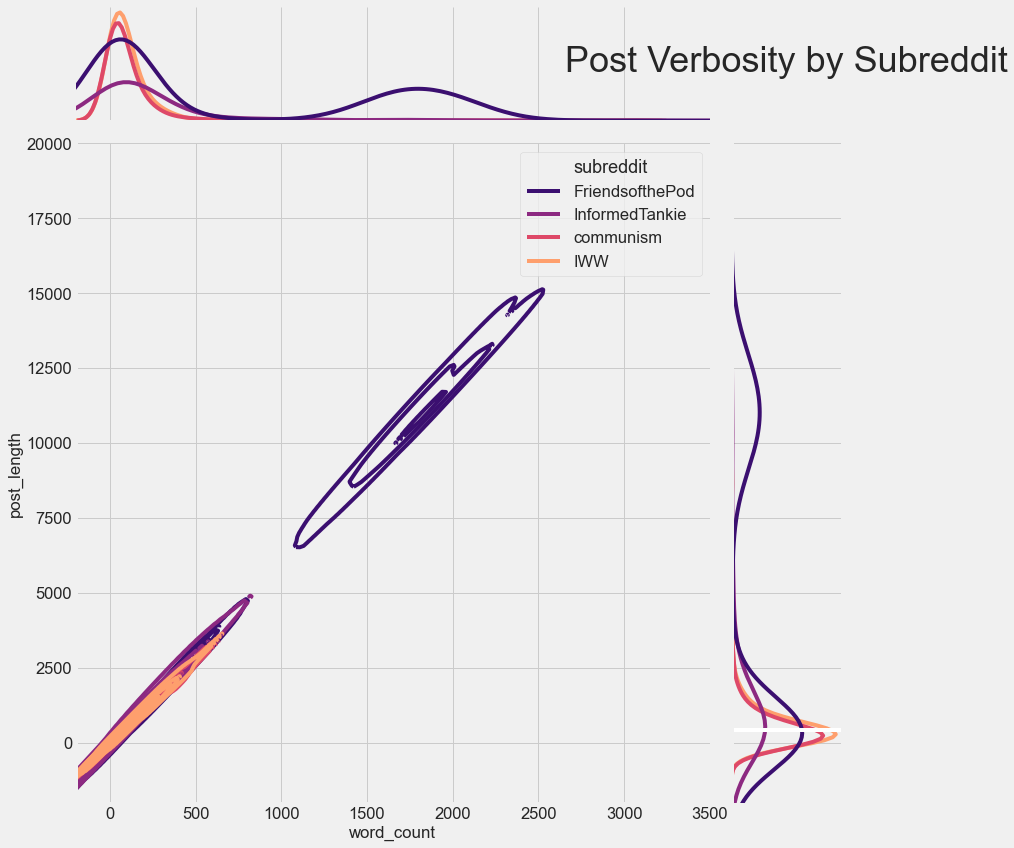

In [29]:
sns.jointplot(data=df, 
           x='word_count', 
           y='post_length',
           hue='subreddit',
           kind='kde', height=12, palette='magma', xlim=[-200, 3500], ylim=[-2000,20000])
plt.axhline(df.post_length.median(), color='white')
plt.xlabel('Word Count')
plt.ylabel('Post Length')
plt.title('Post Verbosity by Subreddit', fontsize=36, y=1.1);

FriendsofthePod clearly has a significant number of longer posts, and I had assumed that this would be useful if passed into the pipeline with ColumnTransformer, but doing so only made the model's predictions worse and ended up not using it

#### Mapping our target classification 
The Liberal subreddit will be coded as *1* while the Left subreddits will be coded as *0* 

In [30]:
df['subreddit'] = df['subreddit'].map({subred1: 1, subred2: 0, subred3: 0, subred4: 0})

---
---
---

In [31]:
# Shuffling the dataset... just because 
# df = df.sample(n=df.shape[0], replace=False, random_state=404)
# df.shape

#### Baseline Accuracy
Checking final distribution and one last look at the DataFrame

In [32]:
df['subreddit'].value_counts(normalize=True)

0    0.511794
1    0.488206
Name: subreddit, dtype: float64

In [33]:
df

,subreddit,title,selftext,post_length,word_count
0,1,help i m an american living it in canada and f...,i m looking to do more than vote this year but...,121,27
1,1,two question in response to that s the ticket,1 is anyone else surprised that biden didn t a...,308,60
2,1,what a day clown v board of education by sarah...,fuck politics but i m always happy to talk to ...,10577,1792
3,1,how do i find the slack channel url,i have heard the slack channel referenced in m...,122,25
4,1,i ve got a strong feeling that pod save the wo...,at best they will probably only briefly mentio...,839,164
...,...,...,...,...,...
3643,0,union by the number organizing work,according to a recent study abacusdata ca woul...,280,53
3644,0,friday iww shop talk,welcome to our weekly shop talk thread use thi...,199,34
3645,0,local,i ve been wanting to join the iww a a working ...,1053,206
3646,0,any member in the st louis area,i just joined the iww a couple day ago and i m...,220,44


In [34]:
df.isnull().sum()

subreddit      0
title          0
selftext       0
post_length    0
word_count     0
dtype: int64

---
### Modeling
---

In [35]:
X = df['selftext'].copy()
Z = df['title'].copy()
y = df['subreddit'].copy()

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape[0] == y_train.shape[0], X_test.shape[0] == y_test.shape[0]

(True, True)

In [37]:
y_test.shape

(1094,)

In [38]:
pipe = Pipeline([
    ("tvec", TfidfVectorizer(stop_words='english',
                            min_df=3,
                            max_df=0.6,
                            )),
#     ("sc", StandardScaler(with_mean=False)),
    ("vc", VotingClassifier(estimators=[
                                        ("lr", LogisticRegression(solver='liblinear')),
                                        ('svc', SVC(degree=2, kernel='rbf', random_state=42,
                                                    probability=True)),
                                        ("rfc", RandomForestClassifier(random_state=42,
                                                                       max_depth=100,
                                                                       min_samples_split=2,
                                                                       min_samples_leaf=3,))],
                            weights=[1, 2, 2], 
                            voting='soft'))
                                        ])

# weights = [[1, 1, 1], [1, 2, 1], [1, 2, 2], [1, 2, 3], 
#            [2, 1, 1], [2, 2, 1], [3, 2, 1], [2, 3, 1]]

pipe_params = {
#     'vc__weights': weights,
    'tvec__max_features': [7500],
    'tvec__ngram_range': [(1, 1)],
#     'vc__voting': ['hard', 'soft'],
    'vc__rfc__max_depth': [100],
    'vc__lr__penalty': ['l2'],
    'vc__svc__max_iter': [1500],
    'vc__svc__C': [20],
    'vc__rfc__n_estimators': [100]
}

vc_gridsearch = GridSearchCV(pipe,
                            param_grid=pipe_params,
                            cv=30,
                            verbose=1,
                            n_jobs=-1)

In [39]:
# pipe.get_params()

In [40]:
%%time
vc_gridsearch.fit(X_train, y_train)
print("Best Score:", vc_gridsearch.best_score_)
print("Best Estimator:", vc_gridsearch.best_estimator_)
print("Best Parameters:", vc_gridsearch.best_params_)

Fitting 30 folds for each of 1 candidates, totalling 30 fits


/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Best Score: 0.9330050159598724
Best Estimator: Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.6, max_features=7500, min_df=3,
                                 stop_words='english')),
                ('vc',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(solver='liblinear')),
                                              ('svc',
                                               SVC(C=20, degree=2,
                                                   max_iter=1500,
                                                   probability=True,
                                                   random_state=42)),
                                              ('rfc',
                                               RandomForestClassifier(max_depth=100,
                                                                      min_samples_leaf=3,
                                                                      random_s

In [41]:
preds = vc_gridsearch.predict(X_test)
print("Train Score:", vc_gridsearch.score(X_train, y_train))
print("Test Score:", vc_gridsearch.score(X_test, y_test))
print()
rmse = mean_squared_error(y_test, preds, squared=False)
print('Accuracy: ', accuracy_score(y_test, preds))
print('Precision:', precision_score(y_test, preds))
print('Recall:   ', recall_score(y_test, preds))
print('F1:   ', f1_score(y_test, preds))

Train Score: 0.9956896551724138
Test Score: 0.946983546617916

Accuracy:  0.946983546617916
Precision: 0.96484375
Recall:    0.9250936329588015
F1:    0.9445506692160611


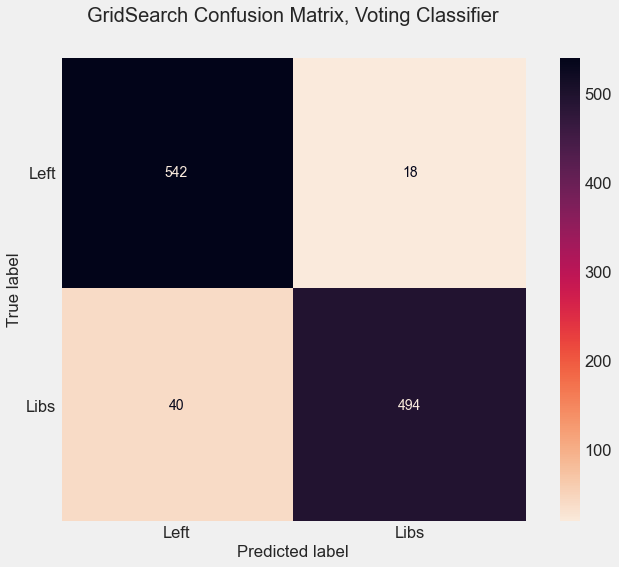

In [42]:
# changed figsize as per https://panjeh.medium.com/figure-size-plot-confusion-matrix-in-scikit-learn-2c66f3a69d81
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(vc_gridsearch, X_test, y_test, 
                      display_labels=['Left', 'Libs'], 
                      normalize=None, 
#                       normalize='all',
                      cmap="rocket_r", ax=ax)
plt.grid(False)
plt.title("GridSearch Confusion Matrix, Voting Classifier", fontsize=20, y=1.06);

This model had the best balance of precision and recall, as seen in the f1 score, while maintaining high accuracy 

## Conclusion
The hypothesis, that it is too difficult to tell the Liberals and the Left apart, seems to be pretty soundly disproven. This was done without relying on any metrics about verbosity or sentiment, or leaning on overabundant pseudo-words left over from the tokenizing process. This shows that Liberals and Leftists really do just talk about very different, distinct things  

---
---

Included below are each of the classifiers from the primary model run with the same hyper-parameters

In [44]:
def single_classifier(classifier_name, classifier):
    """
    This function 
    """
    test_pipe = Pipeline([
        ("tvec", TfidfVectorizer(stop_words='english', max_features=7000, min_df=3, 
                             max_df=0.6, ngram_range=(1, 2),)),
        classifier])
    
    test_params = {}
    
    test_grid = GridSearchCV(test_pipe,
                        param_grid=test_params,
                        cv=30,
                        verbose=1,
                        n_jobs=-1)
    
    test_grid.fit(X_train, y_train)
    
    preds = test_grid.predict(X_test)
    
    print(classifier_name)
    print("Train Score:", test_grid.score(X_train, y_train))
    print("Test Score:", test_grid.score(X_test, y_test))
    print()
    rmse = mean_squared_error(y_test, preds, squared=False)
    print('Accuracy: ', accuracy_score(y_test, preds))
    print('Precision:', precision_score(y_test, preds))
    print('Recall:   ', recall_score(y_test, preds))
    print('F1:   ', f1_score(y_test, preds))
    
    fig, ax = plt.subplots(figsize=(10, 8))
    plot_confusion_matrix(test_grid, X_test, y_test, display_labels=['Left', 'Libs'], 
                          normalize=None, cmap="rocket_r", ax=ax)
    plt.grid(False)
    plt.title(f"GridSearch Confusion Matrix, {classifier_name}", fontsize=20, y=1.06);

Fitting 30 folds for each of 1 candidates, totalling 30 fits
Logistic Regression
Train Score: 0.9753134796238244
Test Score: 0.9387568555758684

Accuracy:  0.9387568555758684
Precision: 0.9642147117296223
Recall:    0.9082397003745318
F1:    0.9353905496624879


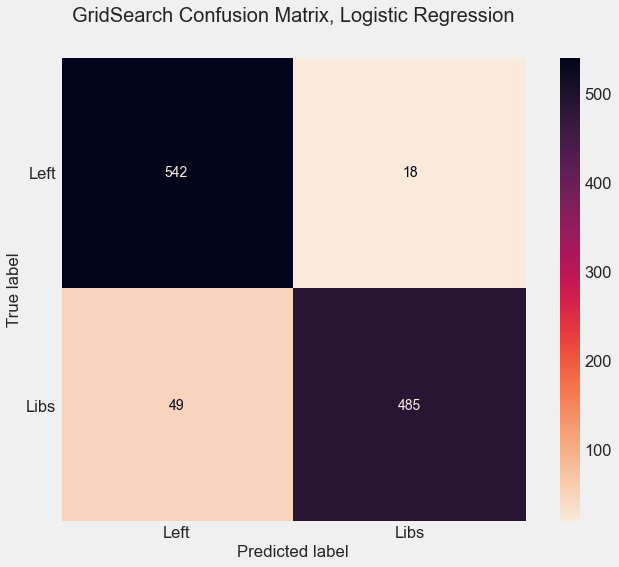

In [53]:
single_classifier('Logistic Regression', ("lr", LogisticRegression(solver='liblinear')))

Fitting 30 folds for each of 1 candidates, totalling 30 fits


/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Support Vector Classifier
Train Score: 0.9933385579937304
Test Score: 0.946983546617916

Accuracy:  0.946983546617916
Precision: 0.9666666666666667
Recall:    0.9232209737827716
F1:    0.9444444444444445


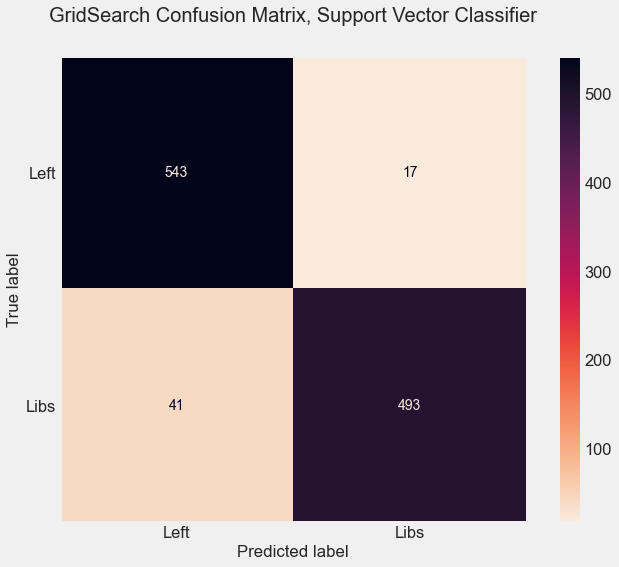

In [46]:
single_classifier('Support Vector Classifier', 
                              ('svc', SVC(degree=2, kernel='rbf', random_state=42, 
                                          probability=True, max_iter=1000)))

Fitting 30 folds for each of 1 candidates, totalling 30 fits
Random Forest Classifier
Train Score: 0.9600313479623824
Test Score: 0.9351005484460695

Accuracy:  0.9351005484460695
Precision: 0.9753593429158111
Recall:    0.8895131086142322
F1:    0.930460333006856


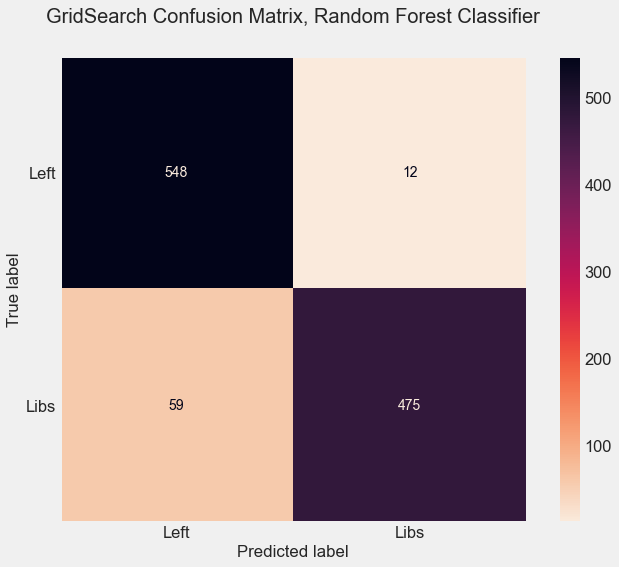

In [47]:
single_classifier('Random Forest Classifier', 
                             ("rfc", RandomForestClassifier(random_state=42, max_depth=100, 
                                                            min_samples_split=2, n_estimators=100, 
                                                            min_samples_leaf=3,)))